In [5]:

from scgen import SCGEN
from thesis import SAVED_RESULTS_PATH
import scanpy as sc
from thesis import DATA_PATH


In [6]:
pbmc_data = DATA_PATH / "pbmc/pbmc.h5ad"
pbmc = sc.read_h5ad(pbmc_data)

In [7]:
pbmc

AnnData object with n_obs × n_vars = 18868 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type', 'batch'
    var: 'gene_symbol', 'n_cells'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [8]:
cell_type_key = 'cell_type'
condition = 'condition'
cell_type_to_predict = 'CD4T'

In [6]:
pbmc.obs.groupby(['condition']).size()

/tmp/ipykernel_676031/225387844.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pbmc.obs.groupby(['condition']).size()


condition
control       8943
stimulated    9925
dtype: int64

In [9]:
train_pbmc = pbmc[~((pbmc.obs['cell_type'] == cell_type_to_predict) & (pbmc.obs['condition'] == "stimulated"))]


In [8]:
train_pbmc.obs.groupby(['condition']).size()

/tmp/ipykernel_676031/2022633694.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_pbmc.obs.groupby(['condition']).size()


condition
control       8943
stimulated    6442
dtype: int64

In [10]:
train_pbmc = train_pbmc.copy() # must be a bug of scvi-tools, needs the copy to setup anndata
SCGEN.setup_anndata(train_pbmc, batch_key=condition, labels_key=cell_type_key)


In [12]:
from thesis.utils import FileModelUtils


model_config = FileModelUtils(
    model_name="scgen",
    dataset_name="pbmc",
    experiment_name="playground",
    perturbation="ifn-b",
    cell_type_key="cell_type",
    root_path=SAVED_RESULTS_PATH,
)

perturbation_path = model_config.get_perturbation_path()


In [13]:
model_path = perturbation_path / "model.pt"

refresh = True

model = SCGEN(adata=train_pbmc)


if model_path.exists() and not refresh:
    model = model.load(str(perturbation_path), adata=train_pbmc)
else:
    model.train(
        max_epochs=100,
        batch_size=32,
        early_stopping=True,
        early_stopping_patience=25
    )
    #model.save(str(perturbation_path), overwrite=True)


/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: 

Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 2/100:   1%|          | 1/100 [00:05<08:32,  5.18s/it, loss=91.8, v_num=1]

/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [30]:
latent_X = model.get_latent_representation()


In [31]:
latent_adata = sc.AnnData(X=latent_X, obs=train_pbmc.obs.copy())


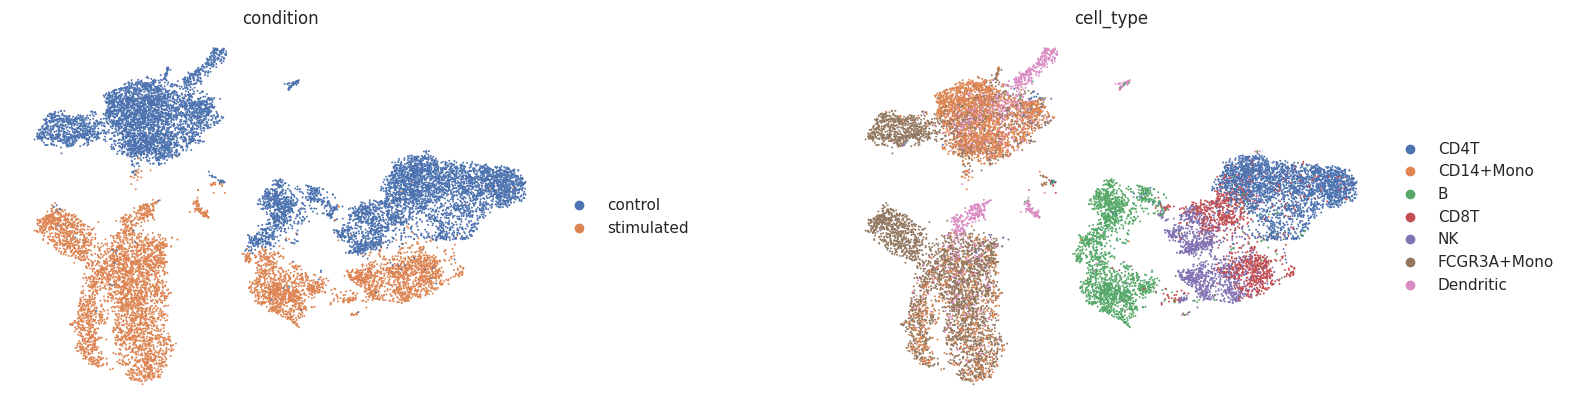

In [32]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=['condition', 'cell_type'], wspace=0.4, frameon=False)


In [33]:
cell_types = pbmc.obs['cell_type'].unique().tolist()
print(cell_types, cell_type_to_predict)
batch = cell_types.index(cell_type_to_predict)

pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='CD4T'
)
pred.obs['condition'] = 'pred'

['NK', 'Dendritic', 'CD4T', 'B', 'FCGR3A+Mono', 'CD14+Mono', 'CD8T'] CD4T
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [34]:
ctrl_adata = pbmc[((pbmc.obs['cell_type'] == cell_type_to_predict) & (pbmc.obs['condition'] == 'control'))]
stim_adata = pbmc[((pbmc.obs['cell_type'] == cell_type_to_predict) & (pbmc.obs['condition'] == 'stimulated'))]

: 

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


saving dotplot to /g/kreshuk/katzalis/repos/thesis/saved_results/scgen/playground/pbmc/ifn-b/dosage0/batch2/dotplot.pdf
Evaluation figs saved to /g/kreshuk/katzalis/repos/thesis/saved_results/scgen/playground/pbmc/ifn-b/dosage0/batch2/evaluation.pdf
Evalution saved /g/kreshuk/katzalis/repos/thesis/saved_results/scgen/playground/pbmc/ifn-b/dosage0/batch2/ground_truth
Evalution saved /g/kreshuk/katzalis/repos/thesis/saved_results/scgen/playground/pbmc/ifn-b/dosage0/batch2/predicted
Writing metrics to /g/kreshuk/katzalis/repos/thesis/saved_results/scgen/playground/pbmc/ifn-b/dosage0/batch2/metrics.csv


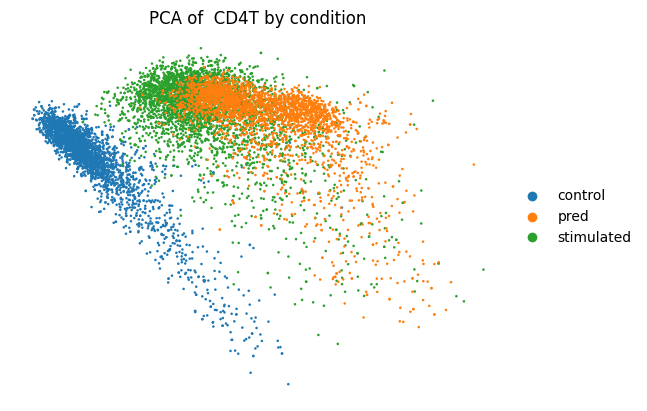

In [21]:
from thesis.evaluation import evaluation_out_of_sample

output_path = model_config.get_batch_path(batch)
evaluation_out_of_sample(
    model_config=model_config,
    input=ctrl_adata,
    ground_truth=stim_adata,
    predicted=pred,
    output_path=output_path,
    append_metrics=False,
    save_plots=True
)

In [22]:
eval_adata = ctrl_adata.concatenate(stim_adata, pred)

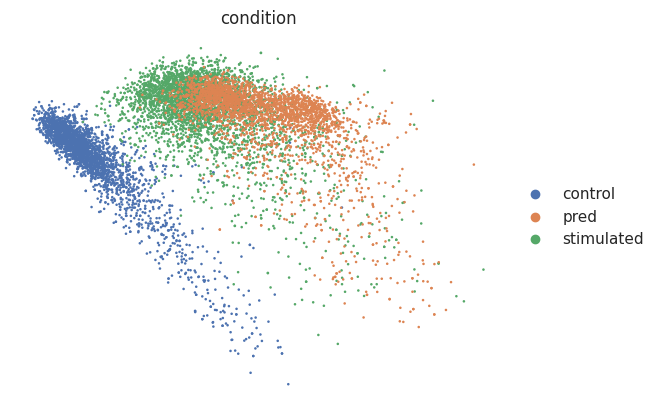

In [23]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False)

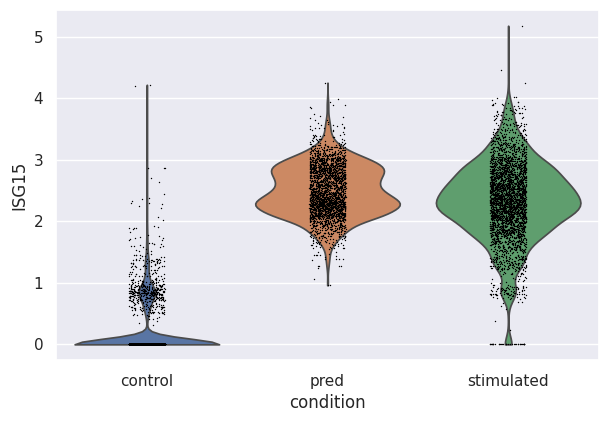

In [24]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")